# Leven at Newby Bridge using HBV model in eWaterCycle
This notebook demonstrates how eWaterCycle is used to run a model. For the EuroCSDMS workshop we, of course, choose the beautiful region we are in as a case study. River discharge in river Leven is measured at the weirs at Newby Bridge, see the photo below. This observational data is available in the CamelsGB dataset (Coxon 20XX). The larger Caravan (collection of Camals...) dataset is available through eWaterCycle and will be used below.

![image](https://upload.wikimedia.org/wikipedia/commons/7/76/Weirs_on_the_River_Leven_at_Newby_Bridge_-_geograph.org.uk_-_5455774.jpg)

As a model we choose the classic HBV model [todo insert HBV ref] for its simplicity. This nicely demonstrates how eWaterCycle works. More complex models are available through eWatercycle, however:

- these often require parameter sets specific to a region
- these are more computationally intensive to run and therefore unsuited for a short 45 minute workshop.

Ask us about available models if you want to collaborate! 

## Starting up
To start up, we need to import eWaterCycle and a number of general Python libraries. 'Under the hood' eWaterCycle depends on a large number of other pieces of software, including but not limited to

- [GRPC4BMI](https://github.com/eWaterCycle/grpc4bmi), a 'translater' for BMI function calls between different programming languages. This library was build by the eWaterCycle team, but is available openly for anyone that can benefit from its functionality. 
- apptainer, a container engine that runs the model-containers
- [ESMValTool](https://github.com/ESMValGroup/ESMValTool), a climate data processing toolbox that originally intended to post-process climate data from CMIP projects for inclusion in IPCC reports, we adopted as tool for pre-processing climate data into forcing data for hydrological models
- Numerous hydrological models that are made available as plugins to eWaterCycle, see [eWaterCycle-leakybucket](https://github.com/eWaterCycle/ewatercycle-leakybucket) as an example. Note that plugins do not have to be owned and maintained by the eWaterCycle team: anyone with a model can make a plugin for eWaterCycle and make their model be available for others through the platform. 

Furthermore, eWaterCycle requires forcing data, obsrvational data and parameter sets to be available to users. If you want to install eWaterCycle on your own infrastructure, see [eWaterCycle-Infra](https://github.com/eWaterCycle/infra) or contact us.

In [1]:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

#niceties
from rich import print

In [2]:
# general eWaterCycle
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing

## Choose region and time period: 
The HBV model is a lumped hydrological model. It considers a catchment as a homogenious area and calculates the major hydrological processes in it. It requires spatially aggregated rainfall and potential evaporation as inputs (ie. forcings). To calculate its modelled discharge at the outlet of the catchment it also needs a set of parameters. Usually these paramters are calibrated using (historical) observational data, so this is also required. 

in eWaterCycle we provide access to the Caravan dataset, which contains all of the above data for all the catchments in the different Camels datasets. However, for two reasons, we don't use the rainfall and potential evaporation data from Caravan

1. This allows us to demonstrate how to generate forcing data for any model from ERA5 (working on ERA5Land) and from CMIP data
2. There is a known problem with the caravan evaporation data and we want to avoid using it here.

We thus only use the Caravan dataset to retreive 

- a shapefile of the region of interest, to be used as input for generating the forcing from ERA5
- the observational data of river discharge

Using the interactive maps at [eWaterCycle caravan map](https://www.ewatercycle.org/caravan-map/) one can easily retrieve the identifier of the catchment.

Note that changing the region below will work, but that the parameters that are loaded later in this notebook are calibrated specifically for this catchment!

In [3]:
camelsgb_id = "camelsgb_73010"

We have to specify start and end date of the experiment that we want to do. For now we don't fuzz with diverences between calibration and validation periods (which officially of course is very bad...)

In [4]:
experiment_start_date = "1997-08-01T00:00:00Z"
experiment_end_date = "2000-08-31T00:00:00Z"



## Set up paths

Since forcing files are often re-used between experiments it is a best practice to save those intermediate files for re-use between experiments. These logical save-points in workflows are called 'rustpunten' [todo: better english]. It is important to store data in 'rustpunten' in standard formats. Working with clearly defined 'rustpunten' is a key element in the design of good workflows in general and was instrumental in designing eWaterCycle in particular. 

Here we set up some paths to store the forcing files we generate in your own home directory. 

To speed up this workshop, we have already created the forcing files in a central location, which we also create pointers to here. If you want to run for a different region, you will have to generate the forcing yourself. 

In [5]:
forcing_path = Path.home() / "Forcing"
forcing_path.mkdir(exist_ok=True)

forcing_path_basin = forcing_path / camelsgb_id 
forcing_path_basin.mkdir(exist_ok=True)

forcing_path_caravan = forcing_path_basin / "caravan"
forcing_path_caravan.mkdir(exist_ok=True)

example_forcing_path_caravan = Path("/home/rhut/Forcing/camelsgb_73010/caravan")

forcing_path_ERA5 = forcing_path_basin / "ERA5"
forcing_path_ERA5.mkdir(exist_ok=True)

example_forcing_path_ERA5 = Path("/home/rhut/Forcing/camelsgb_73010/ERA5")

## Generate or load forcing
There are three options for creating forcing data objects:

- generate from climate data such as ERA5 or CMIP. If the directory you specify as destination already contains data this trying this will throw an error!
- load forcing data you generated previously by providing the location where it was stored
- load forcing data someone else (such as Rolf and Bart) generated previously by providing the location where it was stored

First we will create a caravan forcing object, but as mentioned above, we will only use this for the discharge observations and the shape file of the region. After generating the object we show the fields it contains and plot the discharge data. 

The actual forcing object we will use in this example is the ERA5 based data.

For both caravan and ERA5 based forcing, only one of the three options provided below should be used, use comments to select which one you want to use.

In [6]:
# # option one: generate forcing data
# camelsgb_forcing = ewatercycle.forcing.sources['CaravanForcing'].generate(start_time = experiment_start_date,
#                                                                end_time = experiment_end_date,
#                                                                directory = forcing_path_caravan,
#                                                                basin_id = camelsgb_id,
#                                                                  )

# # option two: load data you generated yourself
# camelsgb_forcing = ewatercycle.forcing.sources['CaravanForcing'].load(directory = forcing_path_caravan)

# option three: load data someone else generated 
camelsgb_forcing = ewatercycle.forcing.sources['CaravanForcing'].load(directory = example_forcing_path_caravan)

In [7]:
print(camelsgb_forcing)

CaravanForcing(
    start_time='1997-08-01T00:00:00Z',
    end_time='2000-08-31T00:00:00Z',
    directory=PosixPath('/home/rhut/Forcing/camelsgb_73010/caravan'),
    shape=PosixPath('/home/rhut/Forcing/camelsgb_73010/caravan/camelsgb_73010.shp'),
    filenames={
        'tasmax': 'camelsgb_73010_1997-08-01_2000-08-31_tasmax.nc',
        'Q': 'camelsgb_73010_1997-08-01_2000-08-31_Q.nc',
        'tasmin': 'camelsgb_73010_1997-08-01_2000-08-31_tasmin.nc',
        'evspsblpot': 'camelsgb_73010_1997-08-01_2000-08-31_evspsblpot.nc',
        'tas': 'camelsgb_73010_1997-08-01_2000-08-31_tas.nc',
        'pr': 'camelsgb_73010_1997-08-01_2000-08-31_pr.nc'
    }
)

<Axes: xlabel='time'>

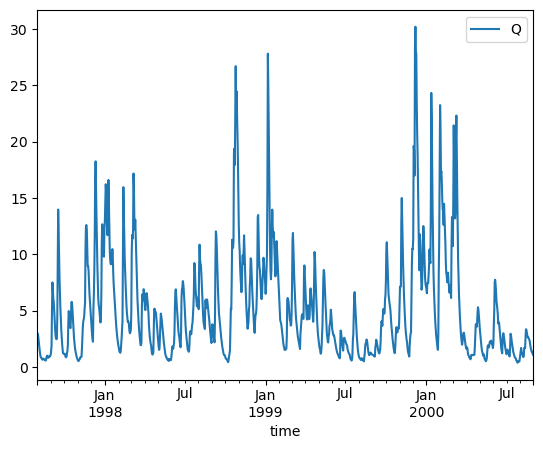

In [8]:
#quick plot of the discharge data. 
ds = xr.open_dataset(camelsgb_forcing['Q'])
caravan_observation_df = ds['Q'].to_dataframe().reset_index()
caravan_observation_df = caravan_observation_df.set_index('time')
caravan_observation_df = caravan_observation_df[['Q']] #NOTE: mm/day
caravan_observation_df.plot()

In [9]:
# # option one: generate forcing:
# ERA5_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].generate(
#    dataset="ERA5",
#    start_time=experiment_start_date,
#    end_time=experiment_end_date,
#    shape=camelsgb_forcing.shape,
#    directory=forcing_path_ERA5
# )

# # option two: load data you generated yourself
# load_location = forcing_path_ERA5 / "work" / "diagnostic" / "script" #this is needed because ERA5 forcing data is stored deep in a sub-directory
# ERA5_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=load_location)

# option three: load data someone else generated for you
load_location = example_forcing_path_ERA5 / "work" / "diagnostic" / "script" #this is needed because ERA5 forcing data is stored deep in a sub-directory
ERA5_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=load_location)

## Load parameters from calibration

The HBV model contains five "stores" where the water is stored and nine parameters that control the flow between those stores and in en out of the model. The ```p_names``` and ```s_names``` variables contain the names of these as human readable and the ```param_names``` and ```stor_names``` contain the names as these variables are known inside the HBV BMI interface.

In [10]:
p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$", "FM"]
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Groundwater storage", "Snowpack storage"]
param_names = ["Imax","Ce",  "Sumax", "Beta",  "Pmax",  "Tlag",   "Kf",   "Ks", "FM"]
stor_names = ["Si", "Su", "Sf", "Ss", "Sp"]

We have already calibrated the model for our region of choise and saved the result in a csv file which we load below. If you have changed the region and have calibrated for your region, you need to point to your calibration results here.

In [11]:
#load calibration constants
par_0 = np.loadtxt("/home/rhut/configFiles/calibration" + camelsgb_id + ".csv", delimiter = ",")
print(par_0)

[4.84323561e+00 9.90022888e-01 8.77879673e+01 2.67298356e+00
 2.93155926e-01 1.29446160e+00 8.36216440e-02 5.45953254e-03
 1.68174394e+00]

For the storages we can specify an array of starting values. If you don't the model will start 'empty' and needs some timesteps to 'fill up': <br>
                Si,  Su, Sf, Ss


In [12]:
s_0 = np.array([0,  100,  0,  5, 0])

## Setting up the model

In [13]:
model = ewatercycle.models.HBV(forcing = ERA5_forcing)

In [14]:
config_file, _ = model.setup(parameters= par_0,initial_storage= s_0)

In [15]:
model.initialize(config_file)

## Running model

In [16]:
Q_m = []
time = []
while model.time < model.end_time:
    model.update()
    Q_m.append(model.get_value("Q"))
    time.append(pd.Timestamp(model.time_as_datetime.date()))

After running the model: finalize to shut everything down

In [17]:
model.finalize()

## Process results

In [18]:
modelOutput = pd.DataFrame(data=Q_m,columns=["Modeled discharge"],index=time)

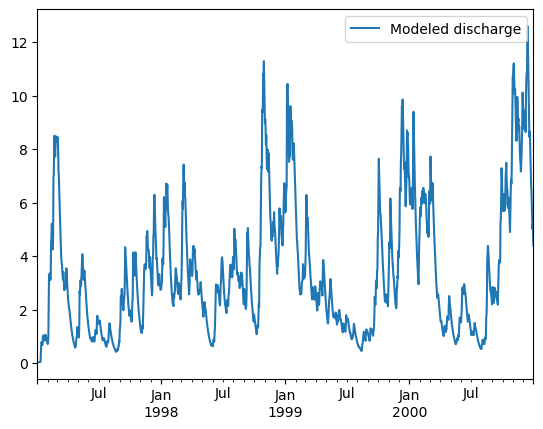

In [19]:
fig, ax = plt.subplots(1,1)
modelOutput.plot(ax=ax,label="Modeled discharge HBV-bmi")
ax.legend(bbox_to_anchor=(1,1));

In [20]:
hydro_data = pd.concat([modelOutput.reindex(caravan_observation_df.index, method = 'ffill'), caravan_observation_df], axis=1)


<Axes: xlabel='time'>

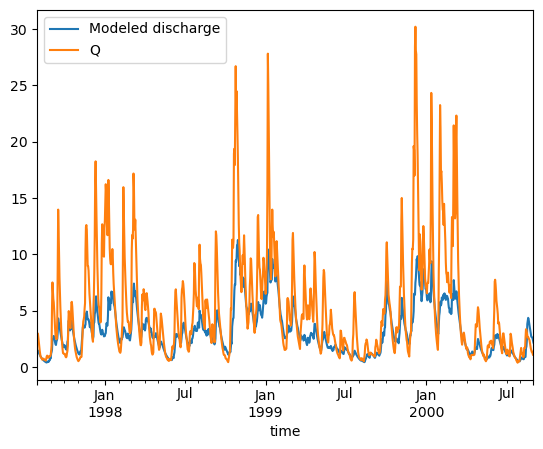

In [21]:
hydro_data.plot()